# CEM


### Assumptions

* $d_t = 0.1$
* maximum velocity ($v_{max}$) = $20 m/s$
* minimum velocity ($v_{min}$) = $0 m/s$
* maximum angular-velocity ($\omega_{max}$) = $0.5 rad/s$
* minimum angular-velocity ($\omega_{min}$) = $-0.5 rad/s$. 
* Assume that the agent and the obstacles are represented as circles each of radius $1$ meters. 

# Algorithm
1. Sample controls from H gaussian distributions inintialized with a user-defined mean and variance
2. Rollout trajectories
3. Score trajectories
4. Get total cost
5. Select top trajectories
6. Update mean and variance

In [78]:
import torch
import numpy as np
# import jax.numpy as jnp
# import jax
import scipy
from matplotlib import pyplot as plt
%matplotlib inline

In [79]:
# Helper function 1
def draw_circle(x, y, radius, col='b'):
    # helper function to draw a circle with a given color
    th = torch.arange(0,2*np.pi,0.01)
    xunit = radius * torch.cos(th) + x
    yunit = radius * torch.sin(th) + y
    plt.plot(xunit, yunit, col)
    return xunit, yunit

# Helper function 2
def unicycle_model(state, controls, dt=0.1):
    a = np.array([
        [np.cos(state[2]), 0],
        [np.sin(state[2]), 0],
        [0, 1]
        ])
    state = state + (a@controls*dt).T
    return state

In [80]:
N = 100 # number of samples/trajectories
H = 30 # horizon for each trajectory
a_dim = 2 # dimension for action space, v and w

In [81]:
v_mean = 5 # starting mean for velocity
v_var = 1 # starting variance for velocity
w_mean = 0 # starting mean for angular velocity
w_var = 1 # starting variance for angular velocity

start_state = torch.tensor([0,0,torch.deg2rad(torch.tensor([90]))]) # the starting state of the vehicle
goal_state = torch.tensor([0,20,torch.deg2rad(torch.tensor([90]))]) # the goal state of the vehicle

obstacle_pose = torch.tensor([[0, 10.0]])

## 1. Sample controls from H gaussian distributions inintialized with a user-defined mean and variance

In [82]:
# initializing variables

#   Initializing control variables sampled from the mean and variance  of linear and angular velocity using a normal distribution
controls_N = np.random.normal([v_mean, w_mean], [v_var, w_var], size=(N,H,2))

#   Initializing trajectory with zeros
traj_N = torch.zeros((N,H+1,3))

# Constraining the 0th ow of the trajectory to be the staring state
traj_N[:, 0, :] = start_state

In [83]:
print("Shape of controls_N = ", controls_N.shape)
print("Shape of traj_N", traj_N.shape)

Shape of controls_N =  (100, 30, 2)
Shape of traj_N torch.Size([100, 31, 3])


## 2. Rollout trajectories

Use the unicycle_model function to rollout the trajectories using the sampled velocities and angular velocities

In [84]:
def rollout_trajectories(controls_N, traj_N):
    for i in range(controls_N.shape[0]):
        for j in range(1, controls_N.shape[1]+1):
            traj_N[i,j] = unicycle_model(traj_N[i, j-1], controls_N[i,j-1].T, dt=0.1) # traj_N[n,h,:] should return the state of the vehicle at timestep h for the n-th ?sample
    return traj_N

traj_N = rollout_trajectories(controls_N, traj_N)


## Display the trajectories

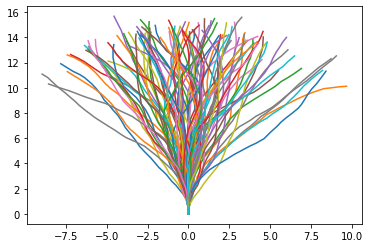

In [85]:
for i in range(N):
    plt.plot(traj_N[i,:,0], traj_N[i,:,1])
plt.show()

## 3. Score trajectories

### 3.1 Collision avoidance cost

Ensures that the sampled trajectories are avoiding obstacles. This function was covered in class during the CEM code implementation

In [86]:
def collision_avoidance_cost_fn(trajs, obstacles, thresh=2.5):
    collision_cost_N = torch.zeros(trajs.shape[0])
    for i in range(collision_cost_N.shape[0]):
        cost_sum = 0
        for j in range(obstacles.shape[0]):
            # Distance between jth obstacle and ith trjectory for each point in the trajectory
            dist = torch.norm(traj_N[i,:,:2] - torch.tensor(obstacles[j]), dim=1)
            cost_sum += 1000*torch.sum(dist<thresh)
        collision_cost_N[i] = cost_sum
    return collision_cost_N

collision_cost = collision_avoidance_cost_fn(traj_N, obstacle_pose)
print("Collision Cost shape = ", collision_cost.shape)

Collision Cost shape =  torch.Size([100])


/tmp/ipykernel_22588/604461831.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.norm(traj_N[i,:,:2] - torch.tensor(obstacles[j]), dim=1)


### 3.2 Smoothness cost

Ensures that the sampled velocities and angular velocities are smooth. That is the difference between $v_h$ and $v_{h-1}$ is minimal. This function was covered in class during the CEM code implementation

In [87]:
def smoothness_cost_fn(controls):
    smoothness_cost = torch.zeros(controls.shape[0])
    for i in range(controls.shape[0]):
        #   Norm of difference of angular velocities which is angular acceleration
        smoothness_cost[i] = torch.norm(torch.diff(torch.tensor(controls[i, :, 1])))
    return smoothness_cost

smoothness_cost = smoothness_cost_fn(controls_N)
print("Smoothness cost", smoothness_cost.shape)

Smoothness cost torch.Size([100])


### 3.3 Goal reaching cost

Ensures that the end-point of the trajectory is close to the goal.

In [88]:
def goal_reaching_cost(traj_N, goal):
    goal_reaching_cost = torch.zeros(traj_N.shape[0])
    for i in range(traj_N.shape[0]):
        #   Norm between last point of the trajectory and goal position
        goal_reaching_cost[i] = torch.norm(traj_N[i, -1,:2] - goal[:2])
    return goal_reaching_cost

goal_cost = goal_reaching_cost(traj_N, goal_state)
print("Goal Reaching Cost = ", goal_cost.shape)

Goal Reaching Cost =  torch.Size([100])


## Total Cost

In [89]:
total_cost = collision_cost + smoothness_cost + 100*goal_cost
print("Total cost = ", total_cost.shape)

Total cost =  torch.Size([100])


## 4. Select the elite trajectories

This was coverd in class as part of the CEM code implementation. Calculate the total cost for each trajectories. A trajectory with less cost is more favorable than a trajectory with higher cost. Use the topk function of torch to get the top k elite trajectories, their controls and their corresponding total_costs.

In [90]:
def get_ellite_set(costs, trajs, controls, k=10):
    top_costs, top_idx = torch.topk(costs, k, largest=False, sorted=True)
    top_trajs = torch.index_select(trajs, 0, top_idx)
    top_controls = torch.index_select(torch.tensor(controls), 0, top_idx)
    return top_costs, top_idx, top_trajs, top_controls

top_costs, top_idxs, top_trajs, top_controls = get_ellite_set(total_cost, traj_N, controls_N)
print("Top Costs Shape = ", top_costs.shape, "\tTop Trajectories Shape = ", top_trajs.shape, "\tTop Controls Shape = ", top_controls.shape)

Top Costs Shape =  torch.Size([10]) 	Top Trajectories Shape =  torch.Size([10, 31, 3]) 	Top Controls Shape =  torch.Size([10, 30, 2])


## 6. Update rules 

Take the mean and variance of the top k trajectories

In [91]:
new_mean = torch.mean(top_controls, dim=0)
new_cov = torch.var(top_controls, dim=0)
print("Shape of new mean = ", new_mean.shape, "\tShape of new covariance = ", new_cov.shape)

Shape of new mean =  torch.Size([30, 2]) 	Shape of new covariance =  torch.Size([30, 2])


## Sample again from the updated distribution. Rollout the trajecories and visualize them. 

In [92]:
controls_N = np.random.normal(new_mean, new_cov, size=(N,H,2))
print(controls_N.shape)
traj_N = torch.zeros((N,H+1,3))
traj_N[:, 0, :] = start_state

(100, 30, 2)


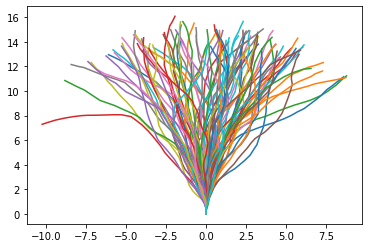

In [93]:
traj_N = rollout_trajectories(controls_N, traj_N)
for i in range(N):
    plt.plot(traj_N[i,:,0], traj_N[i,:,1])
plt.show()

## Repeat the above steps for 10 iterations and visualize the trajectories from the new updated distributions.

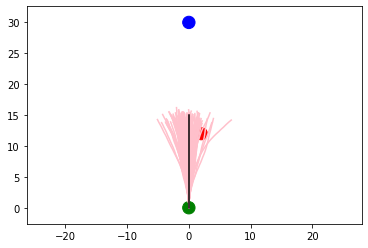

/tmp/ipykernel_22588/604461831.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.norm(traj_N[i,:,:2] - torch.tensor(obstacles[j]), dim=1)


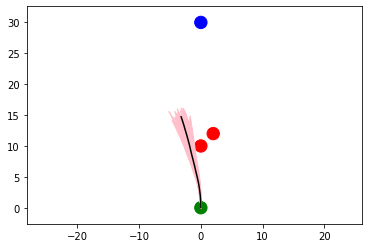

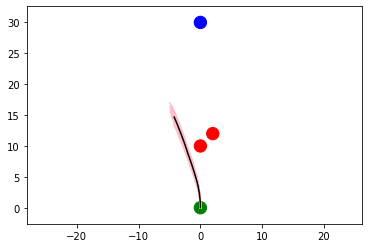

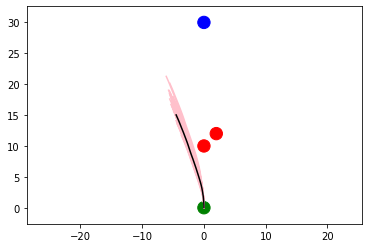

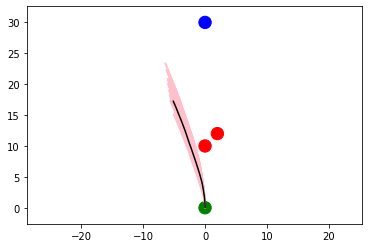

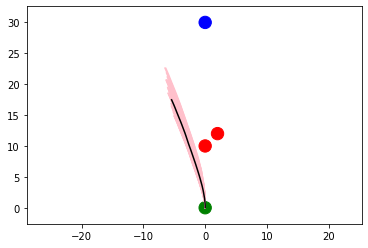

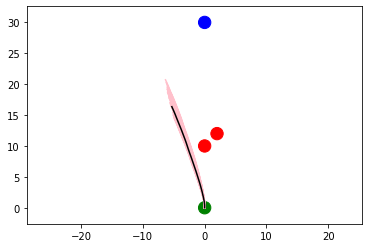

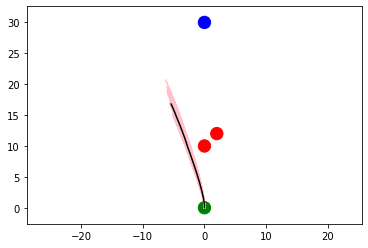

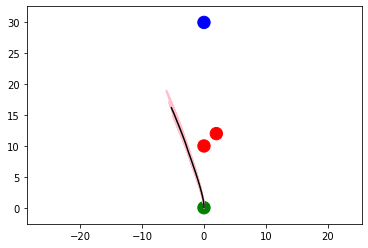

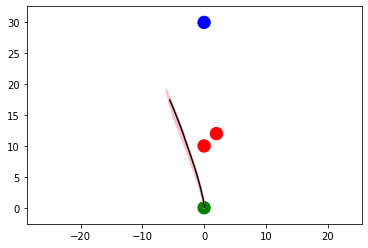

In [97]:
v_mean = 5 # starting mean for velocity
v_var = 1 # starting variance for velocity
w_mean = 0 # starting mean for angular velocity
w_var = 1 # starting variance for angular velocity

start_state = torch.tensor([0,0,torch.deg2rad(torch.tensor([90]))]) # the starting state of the vehicle
goal_state = torch.tensor([0,30,torch.deg2rad(torch.tensor([90]))]) # the goal state of the vehicle

obstacle_pose = torch.tensor([[0, 10.0], [2.0, 12.0]])

#   Initialze means
new_mean = np.array([5, 0])*np.ones((H, 2))
#   Initialze covariances
new_cov = np.array([1,1])*np.ones((H, 2))

#   Initialize controls
controls_N = np.random.normal(new_mean, new_cov, size=(N,H,2))
#   Initialize trajectories
traj_N = torch.zeros((N,H+1,3))
traj_N[:, 0, :] = start_state


for i in range(10):
    #   Sample controls from the new mean and new variance
    controls_N = np.zeros((N, H, 2))
    controls_N[0] = new_mean
    for j in range(1, N):
        for k in range(H):
            controls_N[j, k, 0] = np.random.normal(new_mean[k, 0], new_cov[k, 0])
            controls_N[j, k, 1] = np.random.normal(new_mean[k, 1], new_cov[k, 1])
    # controls_N = np.random.normal(new_mean, new_cov, size=(N,H,2))
    controls_N = torch.clamp(torch.tensor(controls_N), torch.tensor([0.0, -0.5]), torch.tensor([20.0, 0.5])).cpu().detach().numpy()
    # traj_N = torch.zeros((N,H+1,3))

    #   Get trajectories from the sampled controls
    traj_N[:, 0, :] = start_state
    traj_N = rollout_trajectories(controls_N, traj_N)

    #   Plot ego vehicle,obstacles, goal point and trajectories
    ego = plt.Circle((0,0), 1.0, color='green')
    plt.gca().add_patch(ego)
    goal = plt.Circle((goal_state[0], goal_state[1]), 1.0, color='blue')
    plt.gca().add_patch(goal)
    for j in range(N):
        plt.plot(traj_N[j,:,0], traj_N[j,:,1], 'pink')
    plt.plot(traj_N[0,:,0], traj_N[0,:,1], 'black')
    for j in range(len(obstacle_pose)):
        obs = plt.Circle((obstacle_pose[j][0],obstacle_pose[j][1]), 1.0, color='red')
        plt.gca().add_patch(obs)
    plt.axis("equal")
    plt.show()

    #   Get costs
    collision_cost = collision_avoidance_cost_fn(traj_N, obstacle_pose, 3.0)
    smoothness_cost = smoothness_cost_fn(controls_N)
    goal_cost = goal_reaching_cost(traj_N, goal_state)
    total_cost = 10*collision_cost + 1*smoothness_cost + 1*goal_cost

    #   Get ellite trajectories
    top_costs, top_idxs, top_trajs, top_controls = get_ellite_set(total_cost, traj_N, controls_N)

    new_mean = torch.mean(top_controls, dim=0)
    new_cov = torch.var(top_controls, dim=0)

    # # Weights of ellite trajectories
    # weights = exp_util(top_costs)

    # # MPPI update rule
    # new_mean, new_cov = mppi_update(weights, top_controls, torch.tensor([v_mean, w_mean]), torch.tensor([v_var, w_var]), alpha_mean=0.8, alpha_cov=0.5)

## Displaying Final mean trajectory obtained from mean controls along with all controls

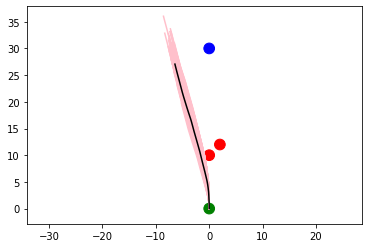

In [20]:
#   Plot ego vehicle,obstacles, goal point and trajectories after final iteration
controls_N = np.zeros((N, H, 2))
controls_N[0] = new_mean
for j in range(1, N):
    for k in range(H):
        controls_N[j, k, 0] = np.random.normal(new_mean[k, 0], new_cov[k, 0])
        controls_N[j, k, 1] = np.random.normal(new_mean[k, 1], new_cov[k, 1])
# controls_N = np.random.normal(new_mean, new_cov, size=(N,H,2))
controls_N = torch.clamp(torch.tensor(controls_N), torch.tensor([0.0, -0.5]), torch.tensor([20.0, 0.5])).cpu().detach().numpy()
# traj_N = torch.zeros((N,H+1,3))

#   Get trajectories from the sampled controls
traj_N[:, 0, :] = start_state
traj_N = rollout_trajectories(controls_N, traj_N)
ego = plt.Circle((0,0), 1.0, color='green')
plt.gca().add_patch(ego)
goal = plt.Circle((goal_state[0], goal_state[1]), 1.0, color='blue')
plt.gca().add_patch(goal)
for j in range(N):
    plt.plot(traj_N[j,:,0], traj_N[j,:,1], 'pink')
plt.plot(traj_N[0,:,0], traj_N[0,:,1], 'black')
for j in range(len(obstacle_pose)):
    obs = plt.Circle((obstacle_pose[j][0],obstacle_pose[j][1]), 1.0, color='red')
    plt.gca().add_patch(obs)
plt.axis("equal")
plt.show()